# <strong><font color='red'>Métodos Descriptivos y Diagnósticos para Entender Datos Históricos</font></strong>

## Librerías
Antes de comenzar a explorar nuestros datos, es importante importar las bibliotecas que nos permitirán manipularlos y visualizarlos. Utilizaremos pandas para trabajar con estructuras tipo DataFrame, numpy para funciones numéricas, y seaborn y matplotlib para gráficos.

In [117]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Configuraciones generales
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

## <strong><font color='blue'>📂 1. Cargar un conjunto de datos históricos</font></strong> 
Los datos históricos reflejan observaciones recolectadas en el pasado y organizadas de forma cronológica. Este tipo de datos se usa frecuentemente para detectar tendencias, estacionalidades o comportamientos anómalos en variables como ventas, temperatura, tráfico o consumo energético.

Simularemos un conjunto de datos de ventas mensuales de una empresa durante cinco años, incluyendo intencionalmente un valor atípico y un valor faltante para fines pedagógicos.


In [118]:
# Simulación de datos originales
np.random.seed(42)
fechas = pd.date_range(start="2019-01-01", end="2023-12-31", freq="M")
ventas_original = np.random.normal(loc=50000, scale=8000, size=len(fechas)).astype(int)

# Crear DataFrame original
df_original = pd.DataFrame({'Fecha': fechas, 'Ventas': ventas_original})

# Introducir outliers y valores faltantes
df_original.loc[10, 'Ventas'] = 120000
df_original.loc[50, 'Ventas'] = 100000
df_original.loc[35, 'Ventas'] = np.nan

## <strong><font color='blue'> 🧾 2. Métodos descriptivos</font></strong>

Los métodos descriptivos permiten obtener una primera comprensión de nuestros datos. Nos ayudan a resumirlos mediante medidas estadísticas (como media o desviación estándar) y visualizaciones que muestran su distribución. Estas técnicas son esenciales para detectar comportamientos esperados o inusuales.

### 🔹2.1 Estadísticas básicas
Mediante funciones como `.describe()`, podemos calcular automáticamente medidas de tendencia central (como la media y la mediana), y de dispersión (como el rango intercuartílico y la desviación estándar). Esto nos da una idea rápida de cómo están distribuidos los datos.

| Estadística      | Descripción                                                        |
|------------------|--------------------------------------------------------------------|
| **count**        | Total de registros sin valores nulos                              |
| **mean**         | Promedio ajustado después de imputación y reemplazo de outliers   |
| **std**          | Desviación estándar — debería haber disminuido tras la limpieza   |
| **min / max**    | Nuevos extremos definidos por la mediana y el límite superior     |
| **25%, 50%, 75%**| Cuartiles que reflejan la distribución post-limpieza              |


In [119]:
df.describe()

,Fecha,Ventas
count,60,63.000000
mean,2021-07-15 16:48:00,50245.365079
min,2019-01-31 00:00:00,34322.000000
25%,2020-04-22 12:00:00,45190.000000
50%,2021-07-15 12:00:00,49074.000000
75%,2022-10-07 18:00:00,55037.000000
max,2023-12-31 00:00:00,70173.500000
std,NaN,8723.916732


Podemos complementar esta salida calculando manualmente algunos indicadores para enfatizar su interpretación:

In [120]:
media = df['Ventas'].mean()
mediana = df['Ventas'].median()
desviacion = df['Ventas'].std()

print(f"Media: {media:.2f}, Mediana: {mediana:.2f}, Desviación estándar: {desviacion:.2f}")


Media: 50245.37, Mediana: 49074.00, Desviación estándar: 8723.92


### 🔹2.2 Distribución de datos

Las distribuciones nos muestran con qué frecuencia se presentan los distintos valores. El histograma es útil para identificar sesgos, multimodalidad o asimetrías. Además, podemos incluir líneas para representar la media y la mediana y compararlas visualmente.

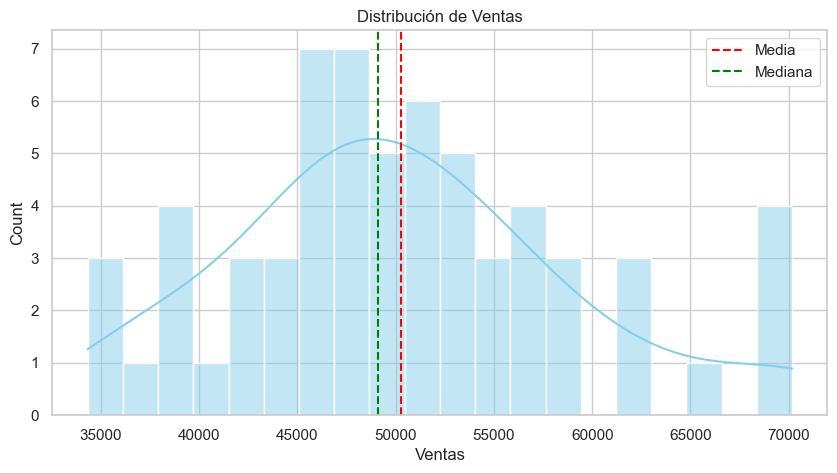

In [121]:
sns.histplot(df['Ventas'], bins=20, kde=True, color='skyblue')
plt.axvline(media, color='red', linestyle='--', label='Media')
plt.axvline(mediana, color='green', linestyle='--', label='Mediana')
plt.title("Distribución de Ventas")
plt.legend()
plt.show()


Este tipo de gráfico también nos ayuda a identificar visualmente valores extremos o concentraciones poco comunes de datos.

## <strong><font color='blue'> 🩺 3. Métodos diagnósticos</font></strong>

Los métodos diagnósticos son estrategias que permiten identificar inconsistencias, errores de captura, valores extremos o patrones sospechosos. Antes de construir modelos o tomar decisiones, es fundamental garantizar la calidad de los datos mediante estos análisis.

### 🔹 3.1 Serie Temporal

Las series temporales permiten observar la evolución de una variable a lo largo del tiempo. Con este tipo de gráfico (línea temporal), podemos visualizar tendencias generales, picos, caídas inesperadas o posibles estacionalidades.

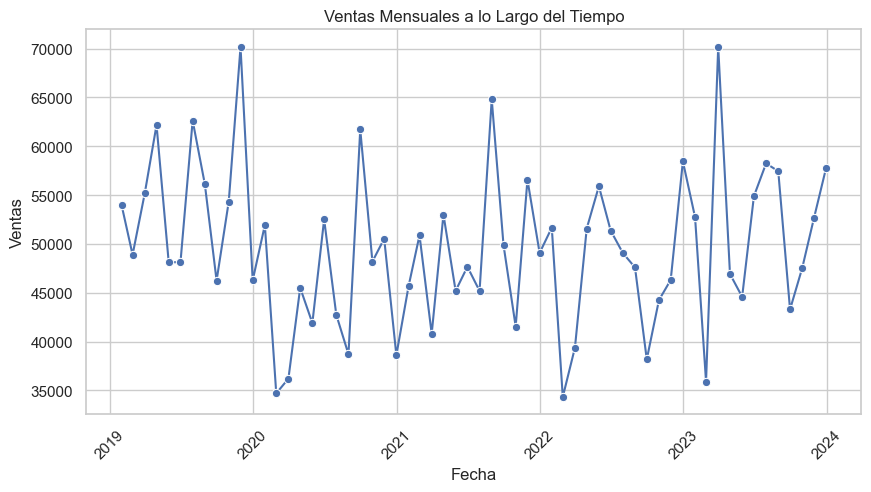

In [122]:
sns.lineplot(x='Fecha', y='Ventas', data=df, marker="o")
plt.title("Ventas Mensuales a lo Largo del Tiempo")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Este tipo de visualización es clave en negocios, meteorología y finanzas, donde el comportamiento a lo largo del tiempo tiene un valor estratégico.

### 🔹 3.2 Detección de outliers

Los outliers o valores atípicos son observaciones que se alejan significativamente del resto. Su presencia puede alterar estadísticas como la media o influir en modelos predictivos. Usamos el diagrama de caja (boxplot) para identificarlos visualmente.

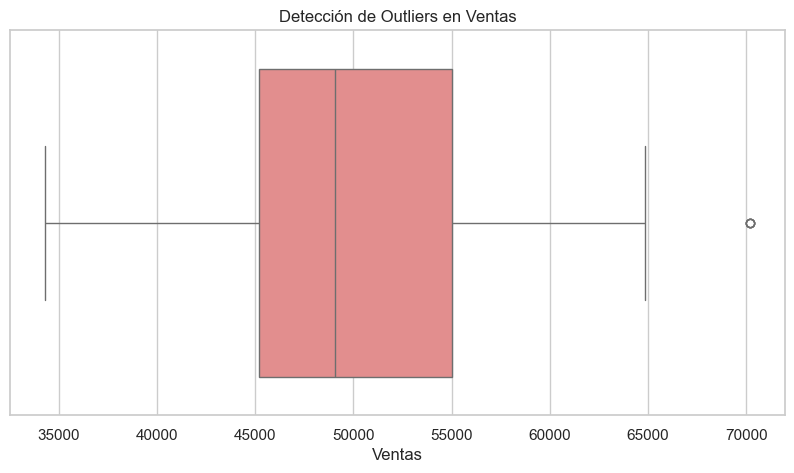

,Fecha,Ventas
10,2019-11-30,70173.5
50,2023-03-31,70173.5
75,NaT,70173.5
90,NaT,70173.5


In [123]:
sns.boxplot(x=df['Ventas'], color='lightcoral')
plt.title("Detección de Outliers en Ventas")
plt.show()

# Complementamos con un análisis estadístico usando el rango intercuartílico (IQR):
# Mostrar valores extremos
q1 = df['Ventas'].quantile(0.25)
q3 = df['Ventas'].quantile(0.75)
iqr = q3 - q1
lim_inf = q1 - 1.5 * iqr
lim_sup = q3 + 1.5 * iqr
outliers = df[(df['Ventas'] < lim_inf) | (df['Ventas'] > lim_sup)]
outliers


### 🔹 3.3 Detección de valores faltantes

Los valores faltantes son comunes en los datos del mundo real. Detectarlos es esencial, ya que pueden afectar cálculos o producir errores al entrenar modelos. Aquí identificamos cuántos valores están perdidos en cada columna.

In [124]:
df.isna().sum()

Fecha     3
Ventas    0
dtype: int64

Existen diversas estrategias para tratarlos: eliminación, imputación con media/mediana/moda, o métodos más avanzados como interpolación o regresión.

## <strong><font color='blue'> 🔨 4. Limpieza y corrección básica</font></strong>

En esta etapa realizamos acciones para corregir los problemas detectados. Es una práctica común imputar valores faltantes con la mediana y reemplazar valores extremos con un límite definido para mantener estabilidad estadística.

In [125]:
# Copia del DataFrame para limpieza
df_limpio = df_original.copy()

# Limpiar: imputar valores faltantes con mediana y limitar outliers con IQR
q1 = df_limpio['Ventas'].quantile(0.25)
q3 = df_limpio['Ventas'].quantile(0.75)
iqr = q3 - q1
lim_inf = q1 - 1.5 * iqr
lim_sup = q3 + 1.5 * iqr

df_limpio['Ventas'] = df_limpio['Ventas'].fillna(df_limpio['Ventas'].median())
df_limpio.loc[df_limpio['Ventas'] > lim_sup, 'Ventas'] = lim_sup

Esta limpieza no busca alterar la naturaleza de los datos, sino prepararlos para un análisis más preciso y confiable.

Después de limpiar los datos, es útil graficarlos nuevamente para verificar si los problemas han sido resueltos. Esto nos da confianza en que el conjunto de datos está listo para futuras etapas como modelado, proyecciones o toma de decisiones.

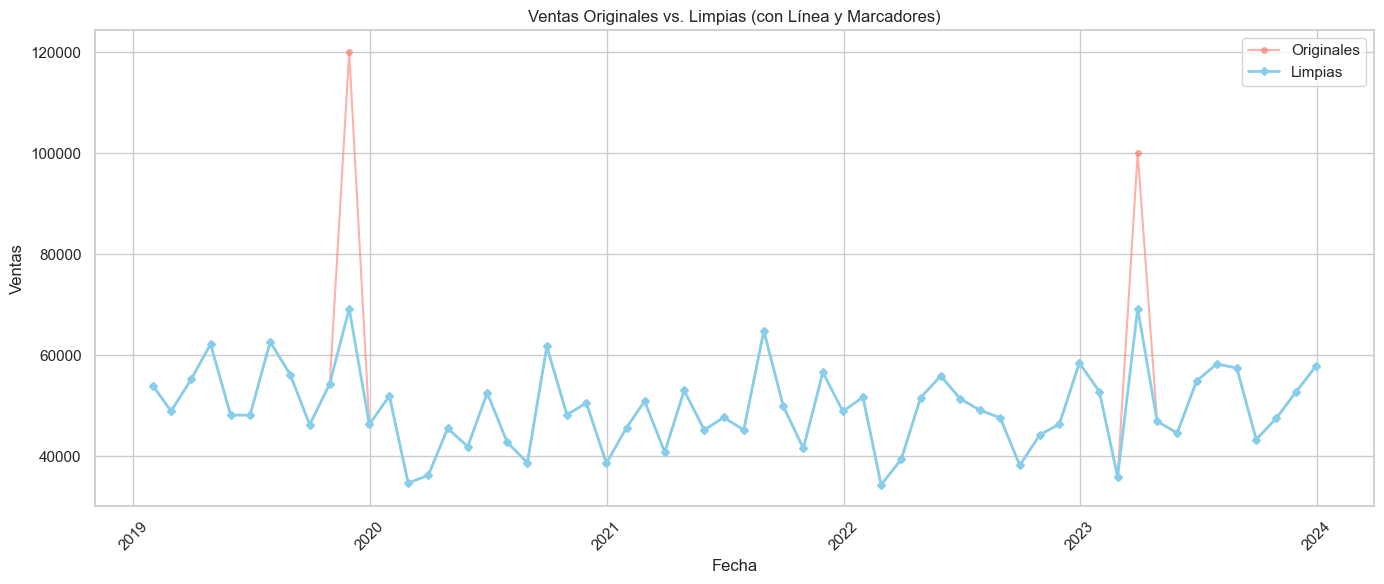

In [126]:
# Crear DataFrame comparativo
df_comparacion = pd.DataFrame({
    'Fecha': fechas,
    'Ventas_Original': df_original['Ventas'],
    'Ventas_Limpias': df_limpio['Ventas']
})

# Graficar ambas versiones
plt.figure(figsize=(14, 6))

# Línea y marcador para ventas originales
plt.plot(df_comparacion['Fecha'], df_comparacion['Ventas_Original'],
         color='salmon', label='Originales', linewidth=1.5, alpha=0.6, marker='o', markersize=4)

# Línea y marcador para ventas limpias
plt.plot(df_comparacion['Fecha'], df_comparacion['Ventas_Limpias'],
         color='skyblue', label='Limpias', linewidth=2, marker='D', markersize=4)

plt.title("Ventas Originales vs. Limpias (con Línea y Marcadores)")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Observa cómo el outlier ha sido suavizado y cómo los huecos han sido completados, haciendo que la serie tenga una forma más coherente.

Preguntas: 
- ¿Qué descubrimientos hiciste con estos métodos?
- ¿Cómo podrían influir estos hallazgos en decisiones de negocio o investigación?

## 📚 Recursos recomendados
- McKinney, W. (2022). Python for Data Analysis. O'Reilly Media.
- Tukey, J. (1977). Exploratory Data Analysis. Addison-Wesley.